# Import visualizaion modules and data

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import warnings
from time import time
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import xgboost as xgb
from lightgbm import LGBMRegressor

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
def eval_train(learner, sample_size, train_X, train_y, test_X, test_y, transform_y, log_constant): 

#     inputs:
#        - learner: the learning algorithm to be trained and predicted on
#        - sample_size: the size of samples (number) to be drawn from training set       
#        - train_X: features training set
#        - train_y: sales training set
#        - test_X: features testing set
#        - test_y: sales testing set

    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(train_X[:sample_size], train_y[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['time_train'] = end - start
        
    # Get the predictions on the test set(X_test),
    start = time() # Get start time
    predictions = learner.predict(test_X)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['time_pred'] = end - start
    
    # Compute R square on Test Set
    if transform_y == 'log':
        results['R2'] = r2_score(np.exp(test_y) - 1 - log_constant, 
                                                       np.exp(predictions) - 1 - log_constant)
    else:
        results['R2'] = r2_score(test_y, predictions)
        
    
    # Compute adjusted R square on Test Set
    results['Adj-R2'] = 1-((1-results['R2'])*(len(train_y)-1)/(len(train_y)-train_X.shape[1]-1))
    
    # Compute Mean Absolute Error on Test Set
    if transform_y == 'log':
        results['MAE'] = mean_absolute_error(np.exp(test_y) - 1 - log_constant, 
                                                       np.exp(predictions) - 1 - log_constant)
    else:
        results['MAE'] = mean_absolute_error(test_y, predictions)
       
            
    # Compute Weighted Mean Absolute Error on Test Set
    if transform_y == 'log':
        results['WMAE'] = weighted_mean_absolute_error(np.exp(test_y) - 1 - log_constant, 
                                                       np.exp(predictions) - 1 - log_constant, 
                                                       compute_weights(test_X['IsHoliday']))
    else:
        results['WMAE'] = weighted_mean_absolute_error(test_y, predictions, compute_weights(test_X['IsHoliday']))
                   
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return (results,learner)

In [4]:
# give holidays 5X weight
def compute_weights(holidays):
    return holidays.apply(lambda x: 1 if x==0 else 5)

In [5]:
# calculate wMAE
def weighted_mean_absolute_error(pred_y, test_y, weights):
    return 1/sum(weights) * sum(weights * abs(test_y - pred_y))

In [6]:
# predict using the remaining 20% split
def predict(models,value_row):
    print('Actual: ',np.exp(val_y[value_row]) - 1 - 0)
    for model in models:
        model_name = model.__class__.__name__
        print(f'{model_name}: ',np.exp(model.predict(val_X.iloc[[value_row]])[0]) - 1 - 0)

In [7]:
#Get data
stores = pd.read_csv("stores.csv")
features = pd.read_csv("features.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
holidays = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08', #Super Bowl
           '2010-09-10', '2011-09-09', '2012-09-07', '2013-02-06',  #Labor Day
           '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  #Thanksgiving
           '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']  #Christmas

# EDA

## 1. stores.csv

In [8]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [9]:
stores.head(10)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [10]:
stores.iloc[44]

Store        45
Type          B
Size     118221
Name: 44, dtype: object

In [11]:
stores.Type.unique()

array(['A', 'B', 'C'], dtype=object)

In [12]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


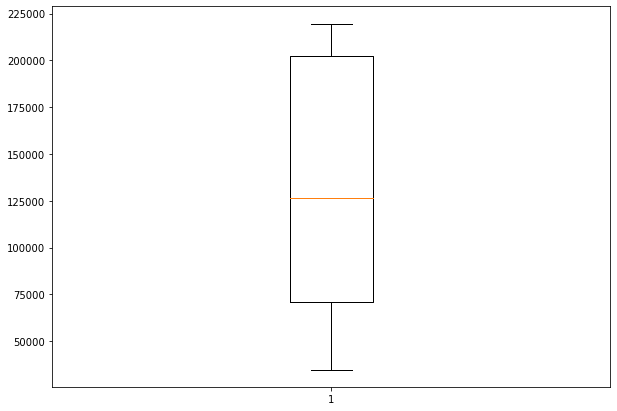

In [13]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(stores.Size)
plt.show()

In [14]:
#missing data
total = stores.isnull().sum().sort_values(ascending=False)
percent = (stores.isnull().sum()/stores.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Store,0,0.0
Type,0,0.0
Size,0,0.0


In [15]:
stores['Size'].groupby(stores['Type']).mean()

Type
A    177247.727273
B    101190.705882
C     40541.666667
Name: Size, dtype: float64

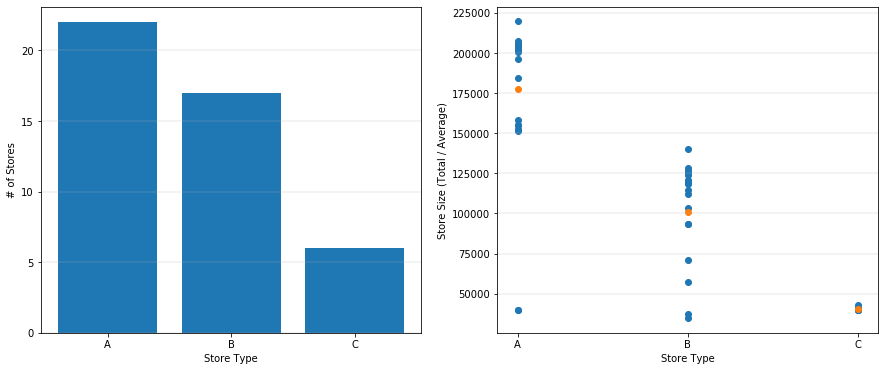

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].bar(stores['Type'].unique(), stores['Size'].groupby(stores['Type']).count())
ax[0].set_ylabel('# of Stores')
ax[0].set_xlabel('Store Type')
ax[0].yaxis.grid(True, linewidth=0.3)

ax[1].scatter(stores['Type'], stores['Size'])
ax[1].scatter(stores['Type'].unique(), stores['Size'].groupby(stores['Type']).mean()) #Store Type Average Store Size Vs 
ax[1].set_ylabel('Store Size (Total / Average)')
ax[1].set_xlabel('Store Type')
ax[1].yaxis.grid(True, linewidth=0.3)

In [17]:
stores[(stores['Size'] < 40000) & (~stores['Type'].isin(['C']))]

,Store,Type,Size
2,3,B,37392
4,5,B,34875
32,33,A,39690
35,36,A,39910


- outliers

### Conclusions
- TYPE column looks like it is directly related to Store Size. Average store size of A is 177k, B is 101k and C is 40k
- stores 3, 5, 33 & 36 whose size is < 40k, seem to have been incorrectly classified as store A & B

## 2. Features.csv

In [18]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


-  MDs , CPI, Unemployment have missing values

In [19]:
features.head(10)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
5,1,2010-03-12,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False
6,1,2010-03-19,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False
7,1,2010-03-26,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False
8,1,2010-04-02,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False
9,1,2010-04-09,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False


In [20]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [21]:
#missing data
total = features.isnull().sum().sort_values(ascending=False)
percent = (features.isnull().sum()/features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
MarkDown2,5269,0.643346
MarkDown4,4726,0.577045
MarkDown3,4577,0.558852
MarkDown1,4158,0.507692
MarkDown5,4140,0.505495
CPI,585,0.071429
Unemployment,585,0.071429
Store,0,0.000000
Date,0,0.000000
Temperature,0,0.000000


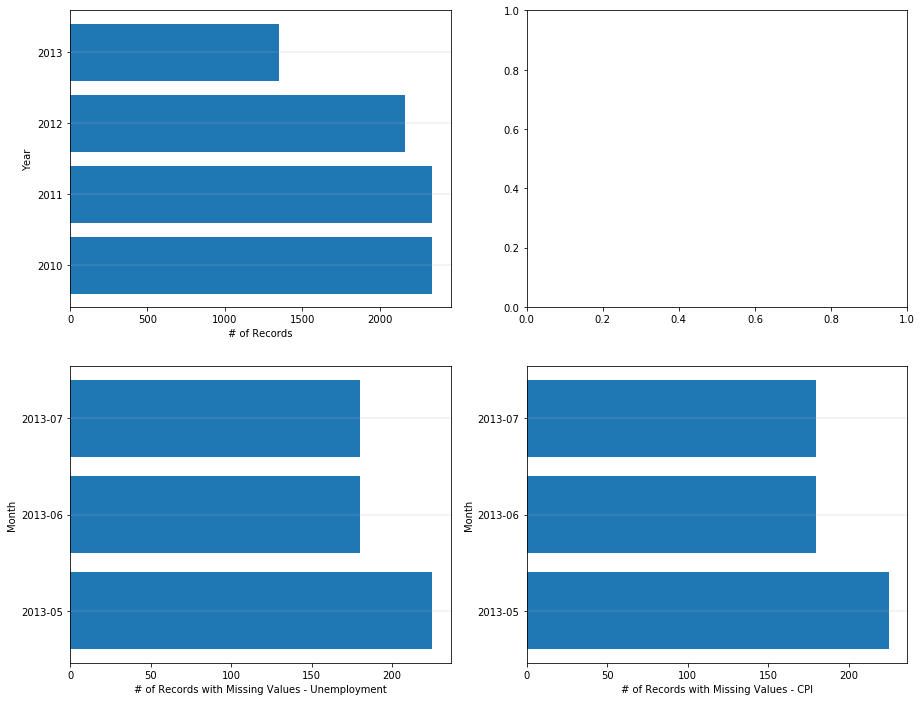

In [22]:
fig, ax = plt.subplots(2, 2, figsize = (15,12))

# Plot 1: Year Vs # of Records
ax[0,0].barh(features['Date'].str.slice(start=0, stop=4).unique(), 
          features['Date'].str.slice(start=0, stop=4).value_counts())
ax[0,0].set_xlabel('# of Records')
ax[0,0].set_ylabel('Year')
ax[0,0].yaxis.grid(True, linewidth=0.3)

# Plot 2: Month Vs # of Records with Missing Values - Unemployment
ax[1,0].barh(features['Date'].str.slice(start=0, stop=7)[features['Unemployment'].isna()].unique(), 
          features['Date'].str.slice(start=0, stop=7)[features['Unemployment'].isna()].value_counts())
ax[1,0].set_xlabel('# of Records with Missing Values - Unemployment')
ax[1,0].set_ylabel('Month')
ax[1,0].yaxis.grid(True, linewidth=0.3)

# Plot 3: Month Vs # of Records with Missing Values - CPI
ax[1,1].barh(features['Date'].str.slice(start=0, stop=7)[features['CPI'].isna()].unique(), 
          features['Date'].str.slice(start=0, stop=7)[features['CPI'].isna()].value_counts())
ax[1,1].set_xlabel('# of Records with Missing Values - CPI')
ax[1,1].set_ylabel('Month')
ax[1,1].yaxis.grid(True, linewidth=0.3)

In [23]:
features[['CPI','Unemployment']].groupby([features['Store'], features['Date'].str.slice(start=0, stop=7)]).mean().head(42)

CPI  Unemployment
Store Date                             
1     2010-02  211.236828         8.106
      2010-03  211.241116         8.106
      2010-04  210.552135         7.808
      2010-05  210.547812         7.808
      2010-06  211.356237         7.808
      2010-07  211.207476         7.787
      2010-08  211.578688         7.787
      2010-09  211.536531         7.787
      2010-10  211.800525         7.838
      2010-11  211.899611         7.838
      2010-12  211.457702         7.838
      2011-01  211.721611         7.742
      2011-02  213.071770         7.742
      2011-03  214.224260         7.742
      2011-04  215.258255         7.682
      2011-05  215.749441         7.682
      2011-06  215.101584         7.682
      2011-07  215.345630         7.962
      2011-08  215.638236         7.962
      2011-09  216.157134         7.962
      2011-10  217.398324         7.866
      2011-11  218.130899         7.866
      2011-12  219.149949         7.866
      2012-01  219.917832         7.348
      2012-02  220.374964         7.348
      2012-03  221.153294         7.348
      2012-04  221.531958         7.143
      2012-05  221.721270         7.143
      2012-06  221.781152         7.143
      2012-07  221.920490         6.908
      2012-08  222.084827         6.908
      2012-09  222.696133         6.908
      2012-10  223.358187         6.573
      2012-11  223.525986         6.573
      2012-12  223.794889         6.573
      2013-01  224.188475         6.525
      2013-02  224.291665         6.525
      2013-03  224.806238         6.525
      2013-04  225.149255         6.314
      2013-05         NaN           NaN
      2013-06         NaN           NaN
      2013-07         NaN           NaN

In [24]:
features[['CPI','Unemployment']].groupby([features['Store'], features['Date'].str.slice(start=0, stop=7)]).mean().head(84)

CPI  Unemployment
Store Date                             
1     2010-02  211.236828         8.106
      2010-03  211.241116         8.106
      2010-04  210.552135         7.808
      2010-05  210.547812         7.808
      2010-06  211.356237         7.808
...                   ...           ...
2     2013-03  224.439928         6.237
      2013-04  224.781713         6.112
      2013-05         NaN           NaN
      2013-06         NaN           NaN
      2013-07         NaN           NaN

[84 rows x 2 columns]

In [25]:
features[['CPI','Unemployment']].groupby([features['Store'], features['Date'].str.slice(start=0, stop=7)]).mean().head(126)

CPI  Unemployment
Store Date                             
1     2010-02  211.236828         8.106
      2010-03  211.241116         8.106
      2010-04  210.552135         7.808
      2010-05  210.547812         7.808
      2010-06  211.356237         7.808
...                   ...           ...
3     2013-03  228.353184         6.108
      2013-04  228.708120         5.999
      2013-05         NaN           NaN
      2013-06         NaN           NaN
      2013-07         NaN           NaN

[126 rows x 2 columns]

- Unemployment and CPI have missing values in months 5, 6, 7 of 2013

In [26]:
# Validate Holidays
features['IsHoliday'][features['Date'].isin(holidays)].value_counts()

True    585
Name: IsHoliday, dtype: int64

In [27]:
features['Date'][features['IsHoliday'].isin([1])][~features['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

- all holidays are in the mentioned range

In [28]:
features.groupby(features['Date'].str.slice(start=0, stop=7))['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'].count()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Date,,,,,
2010-02,0,0,0,0,0
2010-03,0,0,0,0,0
2010-04,0,0,0,0,0
2010-05,0,0,0,0,0
2010-06,0,0,0,0,0
2010-07,0,0,0,0,0
2010-08,0,0,0,0,0
2010-09,0,0,0,0,0
2010-10,0,0,0,0,0


In [29]:
features['Store'][features['MarkDown1'] < 0].count()

4

In [30]:
features['Store'][features['MarkDown2'] < 0].count()

25

In [31]:
features['Store'][features['MarkDown3'] < 0].count()

13

In [32]:
features['Store'][features['MarkDown4'] < 0].count()

0

In [33]:
features['Store'][features['MarkDown5'] < 0].count()

2

- MDs data missing from 02-2010 to 10-2011 (dataset starts from 02-2010 hence can be considered as missing for whole year 2010 )

### Conclusions
-  MDs , CPI, Unemployment have missing values
- Unemployment and CPI have missing values in months 5, 6, 7 of 2013
- Months 5,6,7 values are very similar to month 4
- MDs data missing from 02-2010 to 10-2011 (dataset starts from 02-2010 hence can be considered as missing for whole year 2010 )
- MDs 1,2,3,5 have values less than zero

## 3.Train.csv

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


- no missing data

In [35]:
train.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


In [36]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [37]:
train['Date'].str.slice(start=0, stop=4).value_counts()

2011    153453
2010    140679
2012    127438
Name: Date, dtype: int64

- Almost equally devided btween years

In [38]:
train['IsHoliday'][train['Date'].isin(holidays)].value_counts()

True    29661
Name: IsHoliday, dtype: int64

In [39]:
train['Date'][train['IsHoliday'].isin([1])][~train['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

- all holidays are in the mentioned range

[Text(0, 0, '0'),
 Text(0, 0, '500'),
 Text(0, 0, '1000'),
 Text(0, 0, '1500'),
 Text(0, 0, '>2000')]

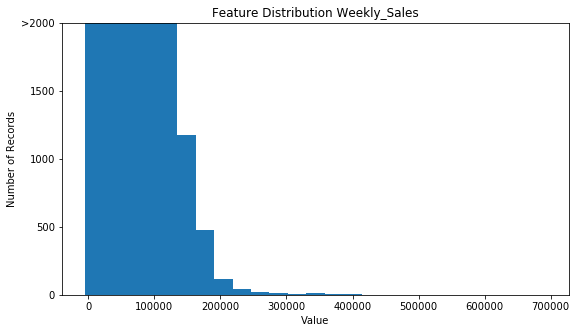

In [40]:
fig = plt.figure(figsize = (20,5));
ax = fig.add_subplot(1, 2, 1)
ax.hist(train['Weekly_Sales'], bins = 25)
ax.set_title( 'Feature Distribution Weekly_Sales', fontsize = 12)
ax.set_xlabel("Value")
ax.set_ylabel("Number of Records")
ax.set_ylim((0, 2000))
ax.set_yticks([0, 500, 1000, 1500, 2000])
ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

In [41]:
train['Store'][train['Weekly_Sales'] < 0].count()

1285

- 1285 weekly sales less than zero

In [42]:
train_merge_Store = pd.merge(train, stores, how='left', on=['Store'])

In [43]:
train_merge_Store.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315
5,1,1,2010-03-12,21043.39,False,A,151315
6,1,1,2010-03-19,22136.64,False,A,151315
7,1,1,2010-03-26,26229.21,False,A,151315
8,1,1,2010-04-02,57258.43,False,A,151315
9,1,1,2010-04-09,42960.91,False,A,151315


In [44]:
train_merge_Store.groupby(['Type'])['Weekly_Sales'].mean()

Type
A    20099.568043
B    12237.075977
C     9519.532538
Name: Weekly_Sales, dtype: float64

- like seen in store.csv, store type is +ve reative to the size and now we see it is +ve relative to weekly sales too 

In [45]:
train_outliers = train_merge_Store[train_merge_Store['Store'].isin([3,5,33,36])]
train_outliers.groupby(['Store','Type'])['Weekly_Sales'].mean()

Store  Type
3      B       6373.033983
5      B       5053.415813
33     A       5728.414053
36     A       8584.412563
Name: Weekly_Sales, dtype: float64

- We can see that  weekly size of store 3,5,33,36 are similar to type C not B and A

In [46]:
train_merge_Store = None
train_outliers = None

### Conclusions
- 1285 weekly sales less than zero
- We can see that weekly size of store 3,5,33,36 are similar to type C not B and A, hence seems to have been incorrectly classified as store A & B

## 4. test.csv

In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [48]:
test.head(10)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
5,1,1,2012-12-07,False
6,1,1,2012-12-14,False
7,1,1,2012-12-21,False
8,1,1,2012-12-28,True
9,1,1,2013-01-04,False


In [49]:
test.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


In [50]:
test['Date'].str.slice(start=0, stop=4).value_counts()

2013    88275
2012    26789
Name: Date, dtype: int64

In [51]:
test['IsHoliday'][test['Date'].isin(holidays)].value_counts()

True    8928
Name: IsHoliday, dtype: int64

In [52]:
test['Date'][test['IsHoliday'].isin([1])][~test['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

### Conclusions
-  Data of year 2012, 2013

# Pre - Processing

### - We found 4 stores miss classified - store 3,5,33,36

In [53]:
stores[stores['Store'].isin([3,5,33,36])].index

Int64Index([2, 4, 32, 35], dtype='int64')

In [54]:
stores.iat[2, 1] = stores.iat[4, 1] = stores.iat[32, 1] = stores.iat[35, 1] = 'C'
#[index , attribute 'type'] 

In [55]:
stores[stores['Store'].isin([3,5,33,36])]

,Store,Type,Size
2,3,C,37392
4,5,C,34875
32,33,C,39690
35,36,C,39910


### - Remove negative values from Weekly Sales

In [56]:
train['Weekly_Sales'] = train['Weekly_Sales'].apply(lambda x: 0 if x < 0 else x)

In [57]:
train['Store'][train['Weekly_Sales'] < 0].count()

0

### - Remove negative values from MDs

In [58]:
features['MarkDown1'] = features['MarkDown1'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown2'] = features['MarkDown2'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown3'] = features['MarkDown3'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown4'] = features['MarkDown4'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown5'] = features['MarkDown5'].apply(lambda x: 0 if x < 0 else x)

### - Substitute Unemployment and CPI missing values in months 5, 6, 7 of 2013 with 4 th month value

In [59]:
for i in range(len(features)):

    if features.iloc[i]['Date'] == '2013-04-26':
        CPI_new = features.iloc[i]['CPI']
        Unemployment_new = features.iloc[i]['Unemployment']
    
    if np.isnan(features.iloc[i]['CPI']):
        features.iat[i, 9] = CPI_new
        features.iat[i, 10] = Unemployment_new

In [60]:
features[['CPI','Unemployment']].groupby([features['Store'], features['Date'].str.slice(start=0, stop=7)]).mean().head(42)

CPI  Unemployment
Store Date                             
1     2010-02  211.236828         8.106
      2010-03  211.241116         8.106
      2010-04  210.552135         7.808
      2010-05  210.547812         7.808
      2010-06  211.356237         7.808
      2010-07  211.207476         7.787
      2010-08  211.578688         7.787
      2010-09  211.536531         7.787
      2010-10  211.800525         7.838
      2010-11  211.899611         7.838
      2010-12  211.457702         7.838
      2011-01  211.721611         7.742
      2011-02  213.071770         7.742
      2011-03  214.224260         7.742
      2011-04  215.258255         7.682
      2011-05  215.749441         7.682
      2011-06  215.101584         7.682
      2011-07  215.345630         7.962
      2011-08  215.638236         7.962
      2011-09  216.157134         7.962
      2011-10  217.398324         7.866
      2011-11  218.130899         7.866
      2011-12  219.149949         7.866
      2012-01  219.917832         7.348
      2012-02  220.374964         7.348
      2012-03  221.153294         7.348
      2012-04  221.531958         7.143
      2012-05  221.721270         7.143
      2012-06  221.781152         7.143
      2012-07  221.920490         6.908
      2012-08  222.084827         6.908
      2012-09  222.696133         6.908
      2012-10  223.358187         6.573
      2012-11  223.525986         6.573
      2012-12  223.794889         6.573
      2013-01  224.188475         6.525
      2013-02  224.291665         6.525
      2013-03  224.806238         6.525
      2013-04  225.149255         6.314
      2013-05  225.170160         6.314
      2013-06  225.170160         6.314
      2013-07  225.170160         6.314

### - add year and week number

In [61]:
# For each date, retrive the corresponding week number

features['Week'] = 0

for i in range(len(features)):
    features.iat[i, 12] = datetime.date(int(features.iloc[i]['Date'][0:4]), 
                                        int(features.iloc[i]['Date'][5:7]), 
                                        int(features.iloc[i]['Date'][8:10])).isocalendar()[1]
    
features['Year'] = features['Date'].str.slice(start=0, stop=4)

In [62]:
features.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Week,Year
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5,2010
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,6,2010
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,7,2010
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,8,2010
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,9,2010


### - Missing MDs from 2010 to 2011

In [63]:
total = features[features['Year'].isin(['2012','2013'])].isnull().sum().sort_values(ascending=False)
percent = (features[features['Year'].isin(['2012','2013'])].isnull().sum()/
           features[features['Year'].isin(['2012','2013'])].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(4)

,Total,Percent
MarkDown2,1062,0.287805
MarkDown4,528,0.143089
MarkDown3,419,0.113550
MarkDown1,12,0.003252


In [64]:
# For 2010 & 2011 records, for each store, copy over MarkDown values from 2012, 02-2010 to 10-2011

# Iterate through stores
for i in range(1, len(features['Store'].unique())):
    
    # For 2010, iterate through weeks 5 thru 52
    for j in range(5, 52):
        idx = features.loc[(features.Year == '2010') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]
        
    # For 2011, iterate through weeks 1 thru 44
    for j in range(1, 44):
        idx = features.loc[(features.Year == '2011') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]

In [65]:
features.drop(columns=['Year'], axis=1, inplace=True)

In [66]:
features.fillna(0, inplace=True)

In [67]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Week
0,1,2010-02-05,42.31,2.572,34577.06,3579.21,160.53,32403.87,5630.40,211.096358,8.106,False,5
1,1,2010-02-12,38.51,2.548,13925.06,6927.23,101.64,8471.88,6886.04,211.242170,8.106,True,6
2,1,2010-02-19,39.93,2.514,9873.33,11062.27,9.80,8409.31,3402.66,211.289143,8.106,False,7
3,1,2010-02-26,46.63,2.561,9349.61,7556.01,3.20,1219.92,8143.59,211.319643,8.106,False,8
4,1,2010-03-05,46.50,2.625,15441.40,1569.00,10.80,25390.88,8067.61,211.350143,8.106,False,9


### - Merging datasets
- Stores + Features + Train
- Stores + Features + Test

In [68]:
train = pd.merge(train, stores, how='left', on=['Store'])
train = pd.merge(train, features, how='left', on=['Store','Date'])

test = pd.merge(test, stores, how='left', on=['Store'])
test = pd.merge(test, features, how='left', on=['Store','Date'])

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     421570 non-null  float64
 10  MarkDown2     421570 non-null  float64
 11  MarkDown3     421570 non-null  float64
 12  MarkDown4     421570 non-null  float64
 13  MarkDown5     421570 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
 16  IsHoliday_y   421570 non-null  bool   
 17  Week          421570 non-null  int64  
dtypes: b

In [70]:
train.drop(columns=['IsHoliday_y'], axis=1, inplace=True)
test.drop(columns=['IsHoliday_y'], axis=1, inplace=True)

train.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
test.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

## - convert isHoliday to numeric i.e 0 or 1

In [71]:
train['IsHoliday'] = train['IsHoliday'].apply(lambda x: 1 if x==True else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x==True else 0)

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  int64  
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     421570 non-null  float64
 10  MarkDown2     421570 non-null  float64
 11  MarkDown3     421570 non-null  float64
 12  MarkDown4     421570 non-null  float64
 13  MarkDown5     421570 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
 16  Week          421570 non-null  int64  
dtypes: float64(10), int64(5), object(2)
memory usage

In [73]:
train = pd.get_dummies(train, columns=['Type'])
test = pd.get_dummies(test, columns=['Type'])

In [74]:
train['Week'] = test['Week'] = 0

In [75]:
# For each date, retrive the corresponding week number
for i in range(len(train)):
    train.iat[i, 15] = datetime.date(int(train.iloc[i]['Date'][0:4]), 
                                     int(train.iloc[i]['Date'][5:7]), 
                                     int(train.iloc[i]['Date'][8:10])).isocalendar()[1]

In [76]:
for i in range(len(test)):
    test.iat[i, 14] = datetime.date(int(test.iloc[i]['Date'][0:4]), 
                                    int(test.iloc[i]['Date'][5:7]), 
                                    int(test.iloc[i]['Date'][8:10])).isocalendar()[1]

In [77]:
train.to_csv('train_prescaled.csv', index=False)
test.to_csv('test_prescaled.csv', index=False)

In [78]:
train = pd.read_csv("train_prescaled.csv")
test = pd.read_csv("test_prescaled.csv")

In [79]:
submission = test[['Store', 'Dept', 'Date']].copy()
submission['Id'] = submission['Store'].map(str) + '_' + submission['Dept'].map(str) + '_' + submission['Date'].map(str)
submission.drop(['Store', 'Dept', 'Date'], axis=1, inplace=True)

In [80]:
train['Year'] = train['Date'].str.slice(start=0, stop=4)
test['Year'] = test['Date'].str.slice(start=0, stop=4)

In [81]:
train.drop(columns=['Date'], axis=1, inplace=True)
test.drop(columns=['Date'], axis=1, inplace=True)

In [82]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  int64  
 4   Size          421570 non-null  int64  
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     421570 non-null  float64
 8   MarkDown2     421570 non-null  float64
 9   MarkDown3     421570 non-null  float64
 10  MarkDown4     421570 non-null  float64
 11  MarkDown5     421570 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Week          421570 non-null  int64  
 15  Type_A        421570 non-null  int64  
 16  Type_B        421570 non-null  int64  
 17  Type_C        421570 non-null  int64  
 18  Year

In [83]:
test

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C,Year
0,1,1,0,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,44,1,0,0,2012
1,1,1,0,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,45,1,0,0,2012
2,1,1,0,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,46,1,0,0,2012
3,1,1,1,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,47,1,0,0,2012
4,1,1,0,151315,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,48,1,0,0,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,0,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,193.589304,8.335,26,0,1,0,2013
115060,45,98,0,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,193.589304,8.335,27,0,1,0,2013
115061,45,98,0,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,193.589304,8.335,28,0,1,0,2013
115062,45,98,0,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,193.589304,8.335,29,0,1,0,2013


In [84]:
train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C,Year
0,1,1,24924.50,0,151315,42.31,2.572,34577.06,3579.21,160.53,32403.87,5630.40,211.096358,8.106,5,1,0,0,2010
1,1,1,46039.49,1,151315,38.51,2.548,13925.06,6927.23,101.64,8471.88,6886.04,211.242170,8.106,6,1,0,0,2010
2,1,1,41595.55,0,151315,39.93,2.514,9873.33,11062.27,9.80,8409.31,3402.66,211.289143,8.106,7,1,0,0,2010
3,1,1,19403.54,0,151315,46.63,2.561,9349.61,7556.01,3.20,1219.92,8143.59,211.319643,8.106,8,1,0,0,2010
4,1,1,21827.90,0,151315,46.50,2.625,15441.40,1569.00,10.80,25390.88,8067.61,211.350143,8.106,9,1,0,0,2010


### Log Transform Skewed Features

In [85]:
skewed = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
train[skewed] = train[skewed].apply(lambda x: np.log(x + 1))
test[skewed] = test[skewed].apply(lambda x: np.log(x + 1))

In [86]:
train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C,Year
0,1,1,24924.50,0,151315,42.31,2.572,10.450975,8.183177,5.084691,10.386064,8.636113,211.096358,8.106,5,1,0,0,2010
1,1,1,46039.49,1,151315,38.51,2.548,9.541517,8.843360,4.631228,9.044626,8.837397,211.242170,8.106,6,1,0,0,2010
2,1,1,41595.55,0,151315,39.93,2.514,9.197694,9.311386,2.379546,9.037214,8.132607,211.289143,8.106,7,1,0,0,2010
3,1,1,19403.54,0,151315,46.63,2.561,9.143197,8.930231,1.435085,7.107360,9.005109,211.319643,8.106,8,1,0,0,2010
4,1,1,21827.90,0,151315,46.50,2.625,9.644872,7.358831,2.468100,10.142185,8.995737,211.350143,8.106,9,1,0,0,2010


In [87]:
log_constant = 0

In [88]:
train['Weekly_Sales'] = train['Weekly_Sales'].apply(lambda x: np.log(x + 1 + log_constant))

In [89]:
train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C,Year
0,1,1,10.123647,0,151315,42.31,2.572,10.450975,8.183177,5.084691,10.386064,8.636113,211.096358,8.106,5,1,0,0,2010
1,1,1,10.737277,1,151315,38.51,2.548,9.541517,8.843360,4.631228,9.044626,8.837397,211.242170,8.106,6,1,0,0,2010
2,1,1,10.635773,0,151315,39.93,2.514,9.197694,9.311386,2.379546,9.037214,8.132607,211.289143,8.106,7,1,0,0,2010
3,1,1,9.873262,0,151315,46.63,2.561,9.143197,8.930231,1.435085,7.107360,9.005109,211.319643,8.106,8,1,0,0,2010
4,1,1,9.990990,0,151315,46.50,2.625,9.644872,7.358831,2.468100,10.142185,8.995737,211.350143,8.106,9,1,0,0,2010


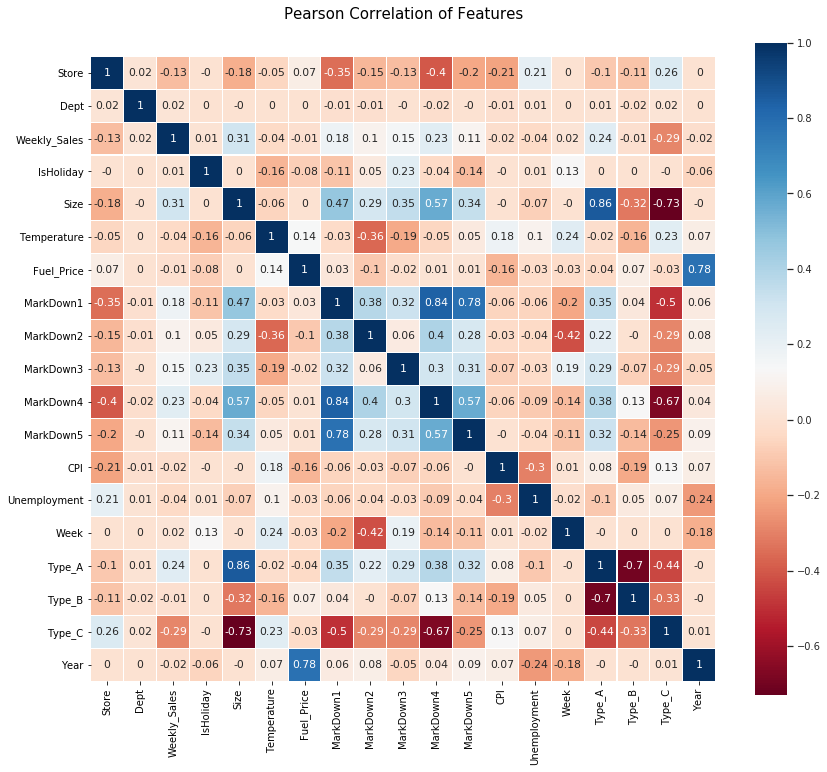

In [90]:
colormap = plt.cm.RdBu
corr = train.astype(float).corr()

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.set(font_scale=0.9)
sns.heatmap(round(corr,2),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

In [91]:
# Check for highly co-related attributes
corr_cutoff = 0.8
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= corr_cutoff:
            if columns[j]:
                columns[j] = False
                
selected_columns = train.columns[columns]
highcorr_columns = train.columns.difference(selected_columns)

In [92]:
highcorr_columns

Index(['MarkDown4', 'Type_A'], dtype='object')

### - MD4 and type A highly corelated to MD1 and Size respectively hence drop them

In [93]:
train.drop(columns=highcorr_columns, axis=1, inplace=True)
test.drop(columns=highcorr_columns, axis=1, inplace=True)

In [94]:
# Split train and test
train_X, val_X, train_y, val_y = train_test_split(train.drop('Weekly_Sales', axis = 1), 
                                                  train['Weekly_Sales'], 
                                                  test_size = 0.2, 
                                                  random_state = 0)

Training set has 337256 samples.
Validation set has 84314 samples.


In [95]:
train_X.shape, train_y.shape, val_X.shape, val_y.shape, test.shape

((337256, 16), (337256,), (84314, 16), (84314,), (115064, 16))

In [96]:
train_X.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Week,Type_B,Type_C,Year
201850,21,32,0,140167,42.72,3.016,8.397734,6.997514,1.495149,8.280029,211.486469,8.028,3,1,0,2011
263688,27,58,0,204184,78.52,2.860,10.141440,4.107754,5.626109,8.594363,136.589112,7.982,35,0,0,2010
147390,15,94,0,123737,59.69,2.840,8.561204,3.031582,0.506818,8.611004,132.756800,8.067,39,1,0,2010
169866,18,19,0,120653,70.92,3.629,9.012843,6.171888,0.862890,8.372063,138.162900,8.304,25,1,0,2012
253398,26,55,0,152513,47.17,3.988,7.574404,3.516013,3.118834,7.674803,134.435733,7.818,17,0,0,2011


### - scale down all values

In [97]:
scaler = MinMaxScaler() # default=(0, 1)

numerical = ['Store', 'Dept', 'IsHoliday', 'Size', 'Temperature', 'Fuel_Price', 
             'CPI', 'Unemployment', 'Week', 'Type_B', 'Type_C',
             'MarkDown1','MarkDown2','MarkDown3','MarkDown5']

train_scaled = pd.DataFrame(data = train_X)
train_scaled[numerical] = scaler.fit_transform(train_X[numerical])

# Show an example of a record with scaling applied
display(train_scaled.head(n = 5))

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Week,Type_B,Type_C,Year
201850,0.454545,0.316327,0.0,0.569925,0.438160,0.272545,0.737133,0.605471,0.125485,0.610801,0.844356,0.397642,0.039216,1.0,0.0,2011
263688,0.590909,0.581633,0.0,0.916437,0.788454,0.194389,0.890191,0.355430,0.472189,0.633988,0.104035,0.393234,0.666667,0.0,0.0,2010
147390,0.318182,0.948980,0.0,0.480993,0.604207,0.184369,0.751482,0.262312,0.042536,0.635216,0.066155,0.401380,0.745098,1.0,0.0,2010
169866,0.386364,0.183673,0.0,0.464300,0.714090,0.579659,0.791126,0.534033,0.072421,0.617590,0.119591,0.424094,0.470588,1.0,0.0,2012
253398,0.568182,0.551020,0.0,0.636752,0.481703,0.759519,0.664863,0.304229,0.261758,0.566154,0.082750,0.377516,0.313725,0.0,0.0,2011


In [98]:
val_scaled = pd.DataFrame(data = val_X)
val_scaled[numerical] = scaler.transform(val_X[numerical])

# Show an example of a record with scaling applied
display(val_scaled.head(n = 5))

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Week,Type_B,Type_C,Year
233571,0.522727,0.551020,0.0,0.914461,0.565656,0.861723,0.865404,0.455363,0.443000,0.627616,0.083527,0.415277,0.333333,0.0,0.0,2011
88992,0.204545,0.102041,0.0,0.496013,0.692955,0.329659,0.805416,0.360259,0.387339,0.496319,0.003681,0.491087,0.823529,1.0,0.0,2010
367842,0.863636,0.591837,0.0,0.807775,0.834638,0.090681,0.781498,0.476005,0.057754,0.802748,0.830627,0.439429,0.470588,0.0,0.0,2010
184359,0.409091,0.602041,0.0,0.914461,0.620157,0.714930,0.817083,0.432713,0.224436,0.672905,0.101840,0.376366,0.725490,0.0,0.0,2011
26175,0.045455,0.448980,0.0,0.013624,0.480724,0.021042,0.693787,0.696427,0.088778,0.545715,0.875328,0.334388,0.117647,0.0,1.0,2010


In [99]:
test_scaled = pd.DataFrame(data = test)
test_scaled[numerical] = scaler.transform(test[numerical])

# Show an example of a record with scaling applied
display(test_scaled.head(n = 5))

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Week,Type_B,Type_C,Year
0,0.0,0.0,0.0,0.630267,0.561448,0.457916,0.774188,0.739500,0.331330,0.583883,0.962735,0.258194,0.843137,0.0,0.0,2012
1,0.0,0.0,0.0,0.630267,0.619374,0.421844,0.820135,0.702875,0.312245,0.643629,0.962918,0.258194,0.862745,0.0,0.0,2012
2,0.0,0.0,0.0,0.630267,0.537965,0.390782,0.805763,0.491516,0.390422,0.648929,0.963231,0.258194,0.882353,0.0,0.0,2012
3,0.0,0.0,1.0,0.630267,0.570352,0.370240,0.595582,0.142152,0.942015,0.421811,0.963716,0.258194,0.901961,0.0,0.0,2012
4,0.0,0.0,0.0,0.630267,0.532290,0.368236,0.685397,0.000000,0.692664,0.652772,0.964200,0.258194,0.921569,0.0,0.0,2012


In [100]:
# Free up memory
train = test = features = stores = None

In [101]:
# Create checkpoint
train_scaled.to_csv('train_X_scaled.csv', index=False)
val_scaled.to_csv('val_X_scaled.csv', index=False)
train_y.to_csv('train_y.csv', index=False, header=['Weekly_Sales'])
val_y.to_csv('val_y.csv', index=False, header=['Weekly_Sales'])
test_scaled.to_csv('test_X_scaled.csv', index=False)

In [102]:
# Restore checkpoint
train_scaled = pd.read_csv("train_X_scaled.csv")
val_scaled = pd.read_csv("val_X_scaled.csv")
train_y = pd.read_csv("train_y.csv")
val_y = pd.read_csv("val_y.csv")
test_scaled = pd.read_csv("test_X_scaled.csv")

In [103]:
train_X = train_scaled
val_X = val_scaled

In [104]:
train_X.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Week,Type_B,Type_C,Year
0,0.454545,0.316327,0.0,0.569925,0.438160,0.272545,0.737133,0.605471,0.125485,0.610801,0.844356,0.397642,0.039216,1.0,0.0,2011
1,0.590909,0.581633,0.0,0.916437,0.788454,0.194389,0.890191,0.355430,0.472189,0.633988,0.104035,0.393234,0.666667,0.0,0.0,2010
2,0.318182,0.948980,0.0,0.480993,0.604207,0.184369,0.751482,0.262312,0.042536,0.635216,0.066155,0.401380,0.745098,1.0,0.0,2010
3,0.386364,0.183673,0.0,0.464300,0.714090,0.579659,0.791126,0.534033,0.072421,0.617590,0.119591,0.424094,0.470588,1.0,0.0,2012
4,0.568182,0.551020,0.0,0.636752,0.481703,0.759519,0.664863,0.304229,0.261758,0.566154,0.082750,0.377516,0.313725,0.0,0.0,2011


In [105]:
# Free up memory
train_scaled = val_scaled = None

In [106]:
# Convert Dataframe to Series
train_y = train_y.iloc[:,0]
val_y = val_y.iloc[:,0]

# Modelling

In [107]:
# Initialize base models
model_A = LinearRegression()
model_B = ElasticNet(random_state=1)
model_C = RandomForestRegressor(random_state=1)
model_D = GradientBoostingRegressor(random_state=1)
model_E = xgb.XGBRegressor()
model_F = LGBMRegressor(random_state=1)

samples = len(train_y)

In [108]:
%%time
# Collect results on the learners
results = {}
models=[]
for model in [model_A, model_B,model_C, model_D, model_E,model_F]:
    model_name = model.__class__.__name__
    results[model_name] = {}
    for i, samples in enumerate([samples]):
        results[model_name][i],m = eval_train(model, samples, train_X, train_y, val_X, val_y, 'log', 0)
        #Save trained models
        pickle.dump(model, open(f'{model_name}.sav', 'wb'))
        models.append(m)

LinearRegression trained on 337256 samples.
ElasticNet trained on 337256 samples.
RandomForestRegressor trained on 337256 samples.
GradientBoostingRegressor trained on 337256 samples.
XGBRegressor trained on 337256 samples.
LGBMRegressor trained on 337256 samples.
CPU times: user 9min 7s, sys: 6.05 s, total: 9min 13s
Wall time: 9min 28s


In [109]:
#restore models
models=[]
for model in [model_A, model_B,model_C, model_D, model_E,model_F]:
    model_name = model.__class__.__name__
    models.append(pickle.load(open(f'{model_name}.sav', 'rb')))

In [110]:
results

{'LinearRegression': {0: {'time_train': 0.43448925018310547,
   'time_pred': 0.007944583892822266,
   'R2': -0.13852002303086852,
   'Adj-R2': -0.13857403908585764,
   'MAE': 13084.812962039196,
   'WMAE': 13288.27899785176}},
 'ElasticNet': {0: {'time_train': 0.15069222450256348,
   'time_pred': 0.0075032711029052734,
   'R2': -0.23844590994777737,
   'Adj-R2': -0.23850466689628913,
   'MAE': 13653.967861415316,
   'WMAE': 13874.268546310475}},
 'RandomForestRegressor': {0: {'time_train': 382.9333620071411,
   'time_pred': 4.243676424026489,
   'R2': 0.9762544110672535,
   'Adj-R2': 0.9762532844792168,
   'MAE': 1393.0131570293786,
   'WMAE': 1546.4126949203096}},
 'GradientBoostingRegressor': {0: {'time_train': 72.31768274307251,
   'time_pred': 0.20742106437683105,
   'R2': 0.5322867395112572,
   'Adj-R2': 0.53226454927772,
   'MAE': 7615.71671279478,
   'WMAE': 7813.675837167311}},
 'XGBRegressor': {0: {'time_train': 11.875946283340454,
   'time_pred': 0.2348318099975586,
   'R2': 

In [112]:
predict(models,1222)

Actual:  6597.580000000001
LinearRegression:  8073.785531030105
ElasticNet:  4921.090374871822
RandomForestRegressor:  6546.840621682168
GradientBoostingRegressor:  8450.654245978294
XGBRegressor:  7236.8203125
LGBMRegressor:  7615.3563295465
